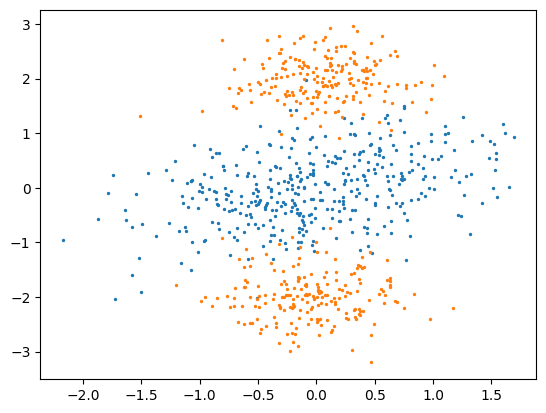

i: 0, loss: 1.2809574012591676
i: 1, loss: 0.9975873836615838
i: 2, loss: 0.844891259448983
i: 3, loss: 0.8168426490215054
i: 4, loss: 0.7167186400881967
i: 5, loss: 0.678950289563959
i: 6, loss: 0.613074920377319
i: 7, loss: 0.5453800941426191
i: 8, loss: 0.5874066451965769
i: 9, loss: 0.46218998126722727
i: 10, loss: 0.48252748952420593
i: 11, loss: 0.46741688223325295
i: 12, loss: 0.45717209756560406
i: 13, loss: 0.48798229453184744
i: 14, loss: 0.4269093425649586
i: 15, loss: 0.38610657956888783
i: 16, loss: 0.40092159496057866
i: 17, loss: 0.40685106994497655
i: 18, loss: 0.4381977475990334
i: 19, loss: 0.40167812141472964
i: 20, loss: 0.43368990820377384
i: 21, loss: 0.403436472016041
i: 22, loss: 0.38335914691221223
i: 23, loss: 0.4098478333298066
i: 24, loss: 0.38747554374996174
i: 25, loss: 0.40613481258292333
i: 26, loss: 0.39878985144527246
i: 27, loss: 0.4172982798053273
i: 28, loss: 0.388376159536183
i: 29, loss: 0.3567331828093898
i: 30, loss: 0.3862666284204386
i: 31, lo

In [177]:
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.models import make_simple_st_nn
from fbs.dsb import ipf_loss, simulate_discrete_time

jax.config.update("jax_enable_x64", True)

# Config
nsamples = 400
nsamples_train = 400
niters = 500
key = jax.random.PRNGKey(666)
nn_float = jnp.float64

nsteps = 10
T = 1.
dt = T / nsteps
ts = jnp.linspace(0, T, nsteps + 1)

nsteps_train = 100
dt_train = T / nsteps_train


# Toy data
def sample_x0s(_key):
    _, _subkey = jax.random.split(_key)
    ss = jax.random.normal(_subkey, (nsamples, 2)) @ jnp.linalg.cholesky(jnp.array([[0.5, 0.2],
                                                                                    [0.2, 0.5]]))
    return jnp.array([0., 0.]) + ss


def sample_xTs(_key):
    _key, _subkey = jax.random.split(_key)
    _c1 = jnp.array([0., 2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    _key, _subkey = jax.random.split(_key)
    _c2 = jnp.array([0., -2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    return jnp.concatenate([_c1, _c2], axis=0)


key, subkey = jax.random.split(key)
x0s = sample_x0s(subkey)
key, subkey = jax.random.split(key)
xTs = sample_xTs(subkey)
plt.scatter(x0s[:, 0], x0s[:, 1], s=2)
plt.scatter(xTs[:, 0], xTs[:, 1], s=2)
plt.show()


# Reference measure Brownian motion
sigma = 1.


# Neural network construction
key, subkey = jax.random.split(key)
_, _, init_param_fwd, _, nn_fwd = make_simple_st_nn(subkey, dim_x=2, batch_size=nsamples_train)
key, subkey = jax.random.split(key)
_, _, init_param_bwd, _, nn_bwd = make_simple_st_nn(subkey, dim_x=2, batch_size=nsamples_train)


# schedule = optax.exponential_decay(1e-2, 10, 0.95)
schedule = optax.cosine_decay_schedule(1e-2, 10, .95)
# schedule = optax.constant_schedule(1e-2)
optimiser = optax.adam(learning_rate=schedule)
f_param = init_param_fwd
b_param = init_param_bwd


# The first IPF iteration
def init_f(x, t, _): return x


@jax.jit
def optax_kernel_init(_b_param, _opt_state, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _key, _subkey = jax.random.split(_key)
    _ts = jnp.hstack([0.,
                      jax.random.uniform(_subkey, (nsteps_train - 1, ), minval=0. + dt_train, maxval=T - dt_train),
                      T])
    # _ts = jnp.linspace(0, T, nsteps_train + 1)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, init_f, _, _x0s, _ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_fwd(_b_param, _opt_state, _f_param, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _key, _subkey = jax.random.split(_key)
    _ts = jnp.hstack([0.,
                      jax.random.uniform(_subkey, (nsteps_train - 1, ), minval=0. + dt_train, maxval=T - dt_train),
                      T])
    # _ts = jnp.linspace(0, T, nsteps_train + 1)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, nn_fwd, _f_param, _x0s, _ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_bwd(_f_param, _opt_state, _b_param, _key):
    _key, _subkey = jax.random.split(_key)
    _xTs = sample_xTs(_subkey)
    _key, _subkey = jax.random.split(_key)
    _ts = jnp.hstack([0.,
                      jax.random.uniform(_subkey, (nsteps_train - 1, ), minval=0. + dt_train, maxval=T - dt_train),
                      T])
    # _ts = jnp.linspace(0, T, nsteps_train + 1)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_f_param, nn_fwd, nn_bwd, _b_param, _xTs, T - _ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _f_param)
    _f_param = optax.apply_updates(_f_param, updates)
    return _f_param, _opt_state, _loss

opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_init(b_param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

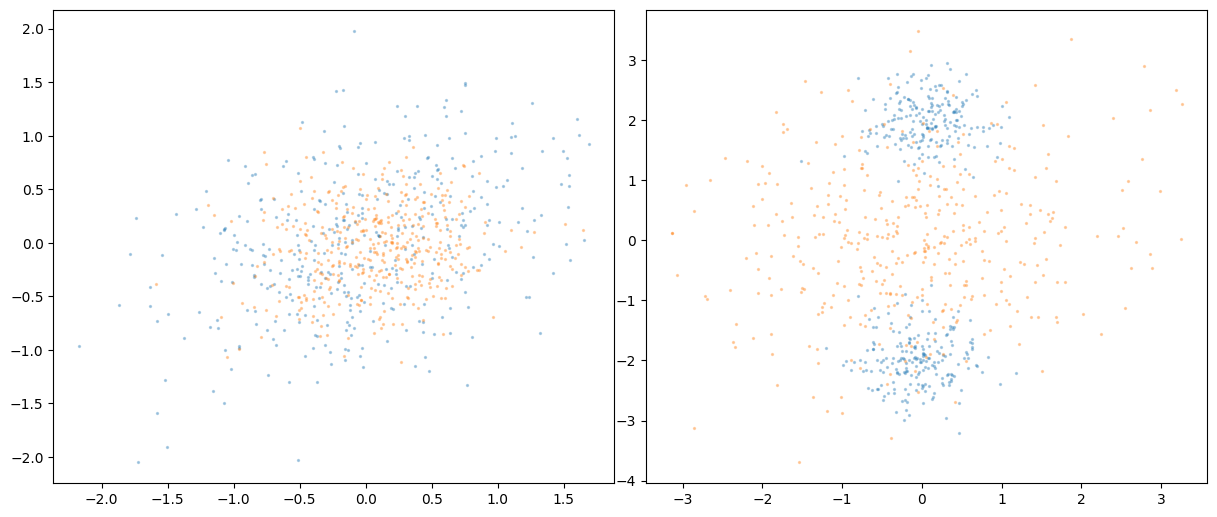

In [178]:
# Test if the reverse is learnt correctly
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(init_f, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, T - ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [179]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 1.9482015300674445
i: 1, loss: 1.6279276171703834
i: 2, loss: 1.0206690402361833
i: 3, loss: 0.5802041125338572
i: 4, loss: 0.4882906833851288
i: 5, loss: 0.4768878934249967
i: 6, loss: 0.43715645647215023
i: 7, loss: 0.34908186422110604
i: 8, loss: 0.33902282234939396
i: 9, loss: 0.35776665461786117
i: 10, loss: 0.3138135203048743
i: 11, loss: 0.31460219727112343
i: 12, loss: 0.29891972467994316
i: 13, loss: 0.3118612005300099
i: 14, loss: 0.31288342465327923
i: 15, loss: 0.29060266876584234
i: 16, loss: 0.3035342101540373
i: 17, loss: 0.29350335820370993
i: 18, loss: 0.294719243378116
i: 19, loss: 0.3214634628450167
i: 20, loss: 0.25819633029737077
i: 21, loss: 0.2806132650552577
i: 22, loss: 0.25146616381722364
i: 23, loss: 0.24048044192531326
i: 24, loss: 0.2641590979187841
i: 25, loss: 0.28039579029582845
i: 26, loss: 0.25135784405141093
i: 27, loss: 0.2369958320816775
i: 28, loss: 0.23858103916639484
i: 29, loss: 0.23513081569829974
i: 30, loss: 0.2172318086403343
i: 

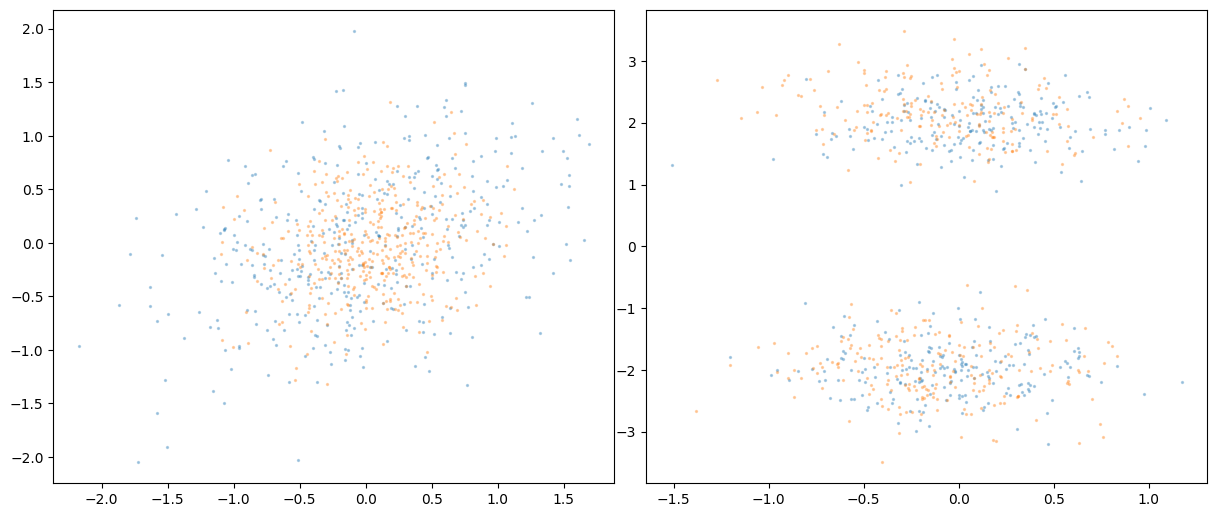

In [180]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, T - ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [181]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.3204750542162331
i: 1, loss: 0.3832596226679437
i: 2, loss: 0.33374010279216737
i: 3, loss: 0.3564018815375976
i: 4, loss: 0.3562171244295263
i: 5, loss: 0.3228120875809777
i: 6, loss: 0.31368601932020923
i: 7, loss: 0.33675248248616857
i: 8, loss: 0.3423879072565099
i: 9, loss: 0.3291659794071182
i: 10, loss: 0.33635204817068554
i: 11, loss: 0.30039112022607634
i: 12, loss: 0.30890030119856016
i: 13, loss: 0.3122213952614148
i: 14, loss: 0.31096922893514994
i: 15, loss: 0.3198398204939282
i: 16, loss: 0.2825332247615146
i: 17, loss: 0.3070915438566568
i: 18, loss: 0.3140040072383012
i: 19, loss: 0.3149419232055446
i: 20, loss: 0.30688341472361635
i: 21, loss: 0.3249947317122345
i: 22, loss: 0.27893141596509186
i: 23, loss: 0.302644269731625
i: 24, loss: 0.2788549133220884
i: 25, loss: 0.30508857367148756
i: 26, loss: 0.33294617822123046
i: 27, loss: 0.3063656721011758
i: 28, loss: 0.3093991261045564
i: 29, loss: 0.28826981927689294
i: 30, loss: 0.28023371770560307
i: 31,

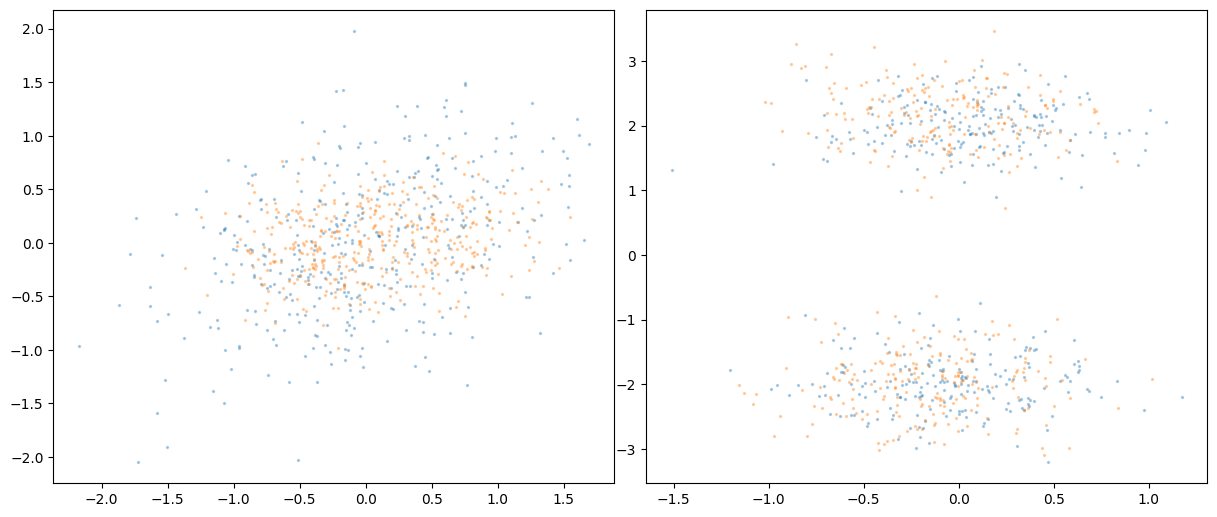

In [182]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, T - ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [183]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.26770688197207154
i: 1, loss: 0.4611552621564909
i: 2, loss: 0.2636540699220943
i: 3, loss: 0.2743784891644703
i: 4, loss: 0.35269766209373077
i: 5, loss: 0.314514560202357
i: 6, loss: 0.2843906551028674
i: 7, loss: 0.2236565462539253
i: 8, loss: 0.23503600245520168
i: 9, loss: 0.23186974703800325
i: 10, loss: 0.2677112679754083
i: 11, loss: 0.255948885794887
i: 12, loss: 0.2271153705421136
i: 13, loss: 0.2400269053287495
i: 14, loss: 0.1952385463082167
i: 15, loss: 0.2578217286694477
i: 16, loss: 0.23385808199888308
i: 17, loss: 0.24670225703366924
i: 18, loss: 0.24910594293533433
i: 19, loss: 0.21291884693659902
i: 20, loss: 0.22048780618337124
i: 21, loss: 0.20280848269699564
i: 22, loss: 0.2368848965115406
i: 23, loss: 0.2079210856385369
i: 24, loss: 0.2180362543135577
i: 25, loss: 0.22051040981579745
i: 26, loss: 0.22350949064388667
i: 27, loss: 0.21108874025252358
i: 28, loss: 0.22108709252683553
i: 29, loss: 0.21876075882118068
i: 30, loss: 0.23422303725026705
i: 3

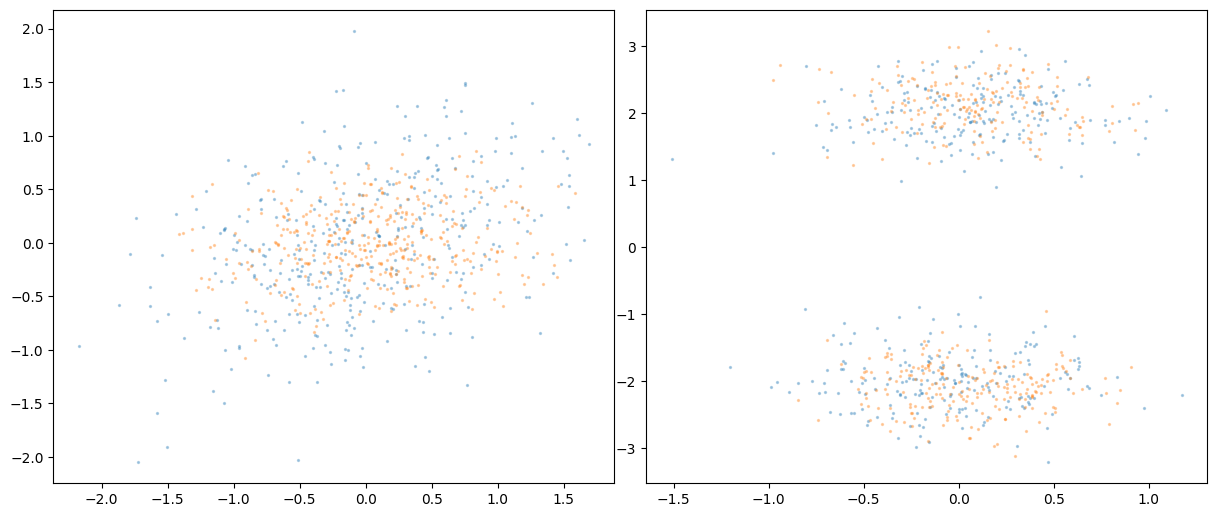

In [184]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, T - ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [185]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.3063185452867665
i: 1, loss: 0.35929644189244814
i: 2, loss: 0.3193133568904261
i: 3, loss: 0.32191462007817107
i: 4, loss: 0.32936184703850013
i: 5, loss: 0.31666072132957535
i: 6, loss: 0.2631208025315754
i: 7, loss: 0.2888787230240894
i: 8, loss: 0.27480902458521506
i: 9, loss: 0.2935100422733121
i: 10, loss: 0.3173635906715285
i: 11, loss: 0.27872477125974165
i: 12, loss: 0.2726686903743
i: 13, loss: 0.27239775052717696
i: 14, loss: 0.25609328449093105
i: 15, loss: 0.29879028484989806
i: 16, loss: 0.2764247442350878
i: 17, loss: 0.2508670457916848
i: 18, loss: 0.2672384652978378
i: 19, loss: 0.26450807760097805
i: 20, loss: 0.32726399276339047
i: 21, loss: 0.29126442672100106
i: 22, loss: 0.2577598299311525
i: 23, loss: 0.2644367196981574
i: 24, loss: 0.26654436258014663
i: 25, loss: 0.28028010958577354
i: 26, loss: 0.27563687453345886
i: 27, loss: 0.30587881515622367
i: 28, loss: 0.27898159589474164
i: 29, loss: 0.2814399381125007
i: 30, loss: 0.25765710470439207
i: 

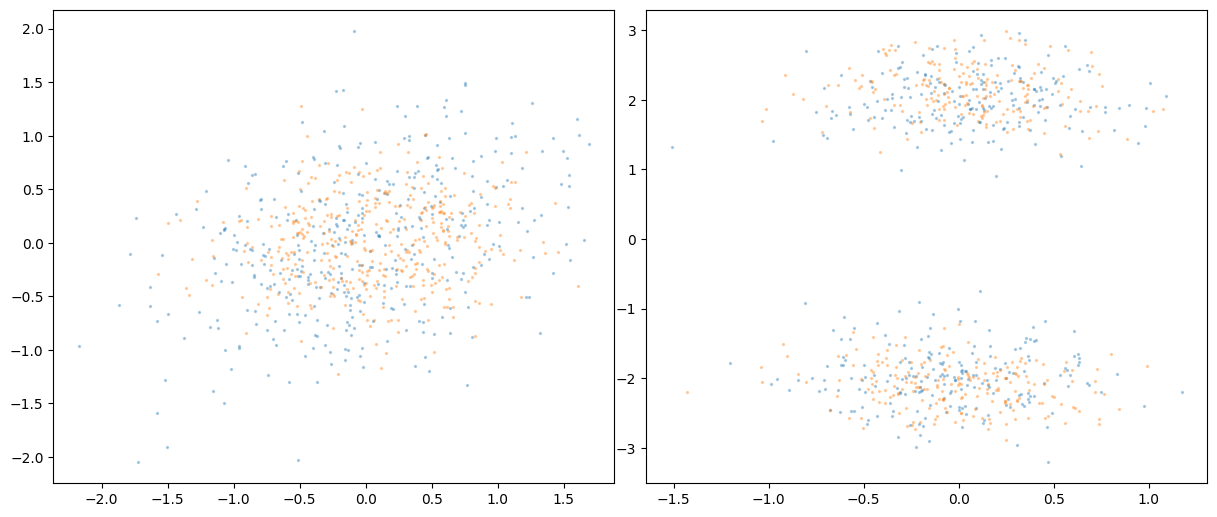

In [186]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, T - ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [187]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.23139271970088818
i: 1, loss: 0.4634265785791915
i: 2, loss: 0.2147421203176829
i: 3, loss: 0.2677423446093188
i: 4, loss: 0.3301967917425832
i: 5, loss: 0.2849614134698281
i: 6, loss: 0.26269026247751676
i: 7, loss: 0.20433313817015938
i: 8, loss: 0.24493549441157758
i: 9, loss: 0.244143324346166
i: 10, loss: 0.26705539461107725
i: 11, loss: 0.2622592780279669
i: 12, loss: 0.2353953320525192
i: 13, loss: 0.22968781551911766
i: 14, loss: 0.22467202079546278
i: 15, loss: 0.2374513408495544
i: 16, loss: 0.22299702448159264
i: 17, loss: 0.24264369902581567
i: 18, loss: 0.21467275524981502
i: 19, loss: 0.23771297666908142
i: 20, loss: 0.1957427526017219
i: 21, loss: 0.24889317521832255
i: 22, loss: 0.2148772057218088
i: 23, loss: 0.23870764297258631
i: 24, loss: 0.18666034589324682
i: 25, loss: 0.22931070234386708
i: 26, loss: 0.18747499517915575
i: 27, loss: 0.19923116664112228
i: 28, loss: 0.19158796155934432
i: 29, loss: 0.19649634868987462
i: 30, loss: 0.23515021621196772

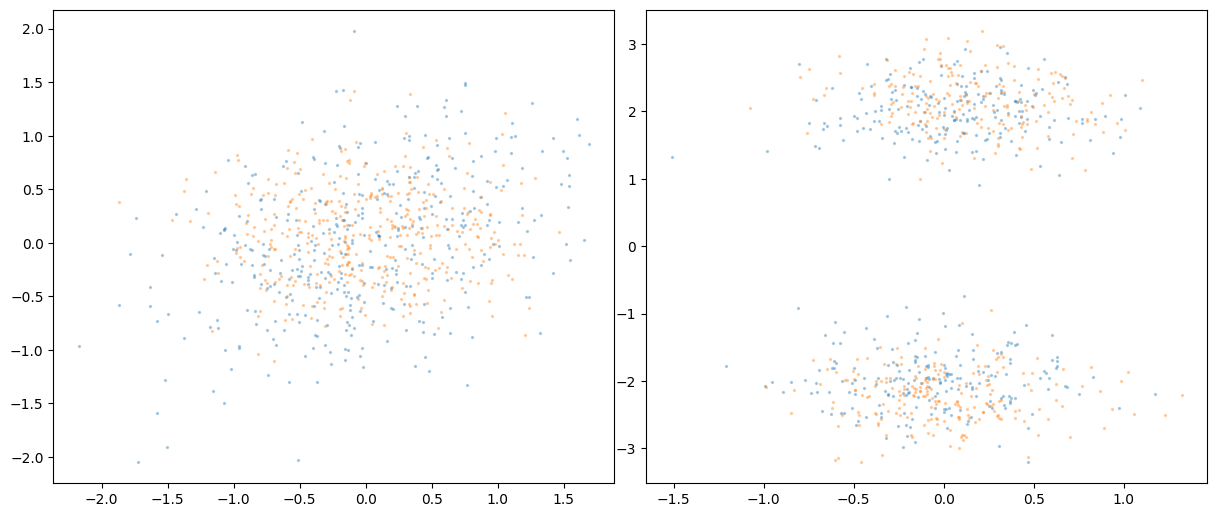

In [188]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, T - ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [189]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.2866963345364099
i: 1, loss: 0.31826172200146885
i: 2, loss: 0.28042549185406435
i: 3, loss: 0.3151933636262607
i: 4, loss: 0.290581787306203
i: 5, loss: 0.2662861748018872
i: 6, loss: 0.2721934124969399
i: 7, loss: 0.27368418374459297
i: 8, loss: 0.26838791995662553
i: 9, loss: 0.2827628100224846
i: 10, loss: 0.2755204439038419
i: 11, loss: 0.27673261597621207
i: 12, loss: 0.26020423305911944
i: 13, loss: 0.2782189844738652
i: 14, loss: 0.26617232692064163
i: 15, loss: 0.23631053083390363
i: 16, loss: 0.2576245232139455
i: 17, loss: 0.26187293085985136
i: 18, loss: 0.2507982514405903
i: 19, loss: 0.26395445579312554
i: 20, loss: 0.249910477811758
i: 21, loss: 0.2803950494100237
i: 22, loss: 0.29251047556528964
i: 23, loss: 0.26539927462715623
i: 24, loss: 0.2507070903024184
i: 25, loss: 0.23440697624226398
i: 26, loss: 0.23104864776428705
i: 27, loss: 0.25266862790574535
i: 28, loss: 0.26977536261214563
i: 29, loss: 0.27262016225008956
i: 30, loss: 0.23999107019815089
i:

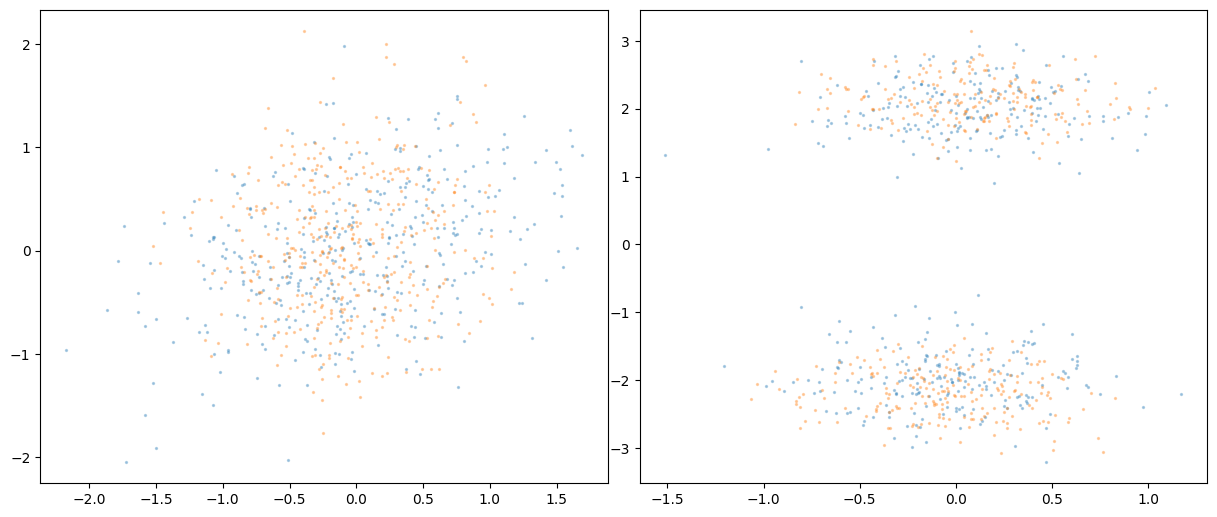

In [190]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, T - ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()